In [3]:
import boto3
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# client=boto3.client('sts')
# account=client.get_caller_identity()['Account']

# my_session=boto3.session.Session()
# region=my_session.region_name

# algorithm_name="pytorch-tft-container-test"
# ecr_image='{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, algorithm_name)

# ecr_image

/opt/conda/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoints/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.29.1
Checkpointing Path: s3://sagemaker-us-east-1-049151007956/checkpoints/checkpoint-f385cb07


In [5]:
import pandas as pd

data_df = pd.read_csv("../dataset-group-by-day.csv")
data_df.groupby(['DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES']).size()
# test_df = pd.read_csv("../HistoricalSalesandActive Inventory_3years_testing_no_header.csv", names=['timestamp','item','store','sales'])

# data_df = pd.concat([data_df, test_df])

DISCHAN  PR_GROUP   MATERIAL  TYPE_JEWEL  STONES
10       PGGB00LN0  G         N           XM        37446
         PGGD0Y0D0  G         D           00        17617
         PSSA00IN0  S         N           XM        15495
dtype: int64

In [6]:
data_df['time_idx'] = pd.DatetimeIndex(data_df["BILLDATE"]).astype(int)/ 86400000000000   # equals to 1 day

data_df.drop(columns = ['BILLDATE'], inplace = True) # drop bill date

data_df['time_idx'] = data_df['time_idx'].astype(int)
data_df['PRODCODE'] = data_df['PRODCODE'].astype(str)
data_df['DISCHAN'] = data_df['DISCHAN'].astype(str)
data_df['solar_month'] = data_df['solar_month'].astype(str)
data_df['solar_day_of_month'] = data_df['solar_day_of_month'].astype(str)
data_df['solar_day_of_week'] = data_df['solar_day_of_week'].astype(str)
data_df['solar_day_of_year'] = data_df['solar_day_of_year'].astype(str)
data_df['lunar_month'] = data_df['lunar_month'].astype(str)
data_df['lunar_day_of_month'] = data_df['lunar_day_of_month'].astype(str)
data_df['MATERIAL'] = data_df['MATERIAL'].astype(str)
data_df['TYPE_JEWEL'] = data_df['TYPE_JEWEL'].astype(str)
data_df['STONES'] = data_df['STONES'].astype(str)
data_df['in_collection'] = data_df['in_collection'].astype(str)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70558 entries, 0 to 70557
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PRODCODE            70558 non-null  object 
 1   DISCHAN             70558 non-null  object 
 2   PR_GROUP            70558 non-null  object 
 3   SOLUONG             70558 non-null  float64
 4   in_collection       70558 non-null  object 
 5   solar_month         70558 non-null  object 
 6   solar_day_of_month  70558 non-null  object 
 7   solar_day_of_week   70558 non-null  object 
 8   solar_day_of_year   70558 non-null  object 
 9   lunar_month         70558 non-null  object 
 10  lunar_day_of_month  70558 non-null  object 
 11  MATERIAL            70558 non-null  object 
 12  TYPE_JEWEL          70558 non-null  object 
 13  STONES              70558 non-null  object 
 14  time_idx            70558 non-null  int64  
dtypes: float64(1), int64(1), object(13)
memory usage: 8.1

In [7]:
import os
import json
def save_local_and_upload_s3(data_df, sagemaker_session, bucket, dir_name = "timeseries_data", data_filename = "data"):
    #create data directory if not exist
    if os.path.isdir(dir_name):
        print("Checkpointing directory {} exists".format(dir_name))
    else:
        print("Creating Checkpointing directory {}".format(dir_name))
        os.makedirs(dir_name)

    data_df.to_parquet('{}/{}.parquet'.format(dir_name, data_filename))   
    print("saved raw data to {}/{}.parquet".format(dir_name, data_filename))
    
    return sagemaker_session.upload_data(path=dir_name, bucket=bucket, key_prefix='data/{}'.format(dir_name))



def metadata_json_upload_s3(training_metadata, sagemaker_session, bucket, dir_name = "timeseries_data", metadata_filename = "data_metadata"):
    #create data directory if not exist
    if os.path.isdir(dir_name):
        print("Checkpointing directory {} exists".format(dir_name))
    else:
        print("Creating Checkpointing directory {}".format(dir_name))
        os.makedirs(dir_name)
    
    with open('{}/{}.json'.format(dir_name, metadata_filename), 'w') as fp:
        json.dump(training_metadata, fp)
        print("saved metadata to {}/{}.json".format(dir_name, metadata_filename))
    
    return sagemaker_session.upload_data(path=dir_name, bucket=bucket, key_prefix='data/{}'.format(dir_name))


In [8]:
import pandas as pd 

inputs = save_local_and_upload_s3(data_df, sagemaker_session, bucket,
                                  dir_name = "timeseries_data/pnj",
                                  data_filename="pnj_training_data")
inputs

Checkpointing directory timeseries_data/pnj exists
saved raw data to timeseries_data/pnj/pnj_training_data.parquet


's3://sagemaker-us-east-1-049151007956/data/timeseries_data/pnj'

In [9]:
# max_prediction_length = 180
max_prediction_length = 7
max_encoder_length = 100

training_metadata = {}
training_metadata['time_idx'] = "time_idx"
training_metadata['target'] = "SOLUONG"
training_metadata['group_ids'] = ["PRODCODE", 'DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES']
training_metadata['min_encoder_length'] = 0      # keep encoder length long (as it is in the validation set)
training_metadata['max_encoder_length'] = max_encoder_length
training_metadata['min_prediction_length'] = 1      
training_metadata['max_prediction_length'] = max_prediction_length
training_metadata['static_categoricals'] = ["PRODCODE", 'DISCHAN', 'PR_GROUP', 'MATERIAL','TYPE_JEWEL', 'STONES']
training_metadata['static_reals'] = []
training_metadata['time_varying_known_categoricals'] = ['solar_month', 'solar_day_of_month', 'solar_day_of_week', 'solar_day_of_year', 'lunar_month', 'lunar_day_of_month']
training_metadata['variable_groups'] = {}
training_metadata['time_varying_known_reals'] = ["time_idx"]
training_metadata['time_varying_unknown_categoricals'] = ['in_collection']
training_metadata['time_varying_unknown_reals'] = []
training_metadata['target_normalizer'] = {
                            "normalized_groups": ["PRODCODE", 'DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES'],
                            "normalization_transformation": 'softplus'
                        }
training_metadata['dimensions_w_potentially_unseen_values'] = ["PRODCODE", 'DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES',
                                                              "lunar_month", "solar_day_of_year"]
training_metadata['add_relative_time_idx'] = True
training_metadata['add_target_scales'] = True
training_metadata['add_encoder_length'] = True
training_metadata['allow_missing_timesteps'] = True

training_metadata['training_cutoff'] = int(data_df["time_idx"].max() - max_prediction_length)
# training_metadata['training_cutoff'] = int(data_df["time_idx"].max())

# upload metadata
metadata_json_upload_s3(training_metadata, sagemaker_session, bucket,
                                    dir_name = "timeseries_data/pnj",
                                    metadata_filename="pnj_metadata")

Checkpointing directory timeseries_data/pnj exists
saved metadata to timeseries_data/pnj/pnj_metadata.json


's3://sagemaker-us-east-1-049151007956/data/timeseries_data/pnj'

In [10]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.data import encoders

cat_encoders = {}
for cat in training_metadata['dimensions_w_potentially_unseen_values']:
    cat_encoders[cat] = encoders.NaNLabelEncoder(add_nan=True)

train_df = data_df[lambda x: x[training_metadata['time_idx']] <= training_metadata['training_cutoff']]
val_df = data_df[lambda x: x[training_metadata['time_idx']] > training_metadata['training_cutoff']]
val_df

,PRODCODE,DISCHAN,PR_GROUP,SOLUONG,in_collection,solar_month,solar_day_of_month,solar_day_of_week,solar_day_of_year,lunar_month,lunar_day_of_month,MATERIAL,TYPE_JEWEL,STONES,time_idx
16819,GD0000C060063.450,10,PGGD0Y0D0,1.0,True,9,24,5,267,8,29,G,D,00,19259
16820,GD0000W000001.420,10,PGGD0Y0D0,1.0,True,9,24,5,267,8,29,G,D,00,19259
16821,GD0000W000224.420,10,PGGD0Y0D0,4.0,True,9,24,5,267,8,29,G,D,00,19259
16822,GD0000W000224.450,10,PGGD0Y0D0,10.0,True,9,24,5,267,8,29,G,D,00,19259
16823,GD0000W000225.420,10,PGGD0Y0D0,13.0,True,9,24,5,267,8,29,G,D,00,19259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70553,SNXMXMW060103.190,10,PSSA00IN0,1.0,False,9,30,4,273,9,5,S,N,XM,19265
70554,SNXMXMW060104.190,10,PSSA00IN0,1.0,False,9,30,4,273,9,5,S,N,XM,19265
70555,SNXMXMW060107.170,10,PSSA00IN0,1.0,False,9,30,4,273,9,5,S,N,XM,19265
70556,SNXMXMW060107.190,10,PSSA00IN0,3.0,False,9,30,4,273,9,5,S,N,XM,19265


In [11]:
# # refine validation dataframe to only contain elements already seen in train dataframe
# for category_dimension in training_metadata['group_ids']:
#     val_df = val_df[val_df[category_dimension].isin(train_df[category_dimension].unique())]

# val_df

In [12]:
training = TimeSeriesDataSet(
        train_df,
        time_idx= training_metadata['time_idx'],
        target= training_metadata['target'],
        group_ids= training_metadata['group_ids'],
        min_encoder_length= training_metadata['min_encoder_length'],  
        max_encoder_length= training_metadata['max_encoder_length'],
        min_prediction_length=training_metadata['min_prediction_length'],
        max_prediction_length=training_metadata['max_prediction_length'],
        static_categoricals=training_metadata['static_categoricals'],
        static_reals=training_metadata['static_reals'],
        time_varying_known_categoricals=training_metadata['time_varying_known_categoricals'],
        variable_groups= training_metadata['variable_groups'],  # group of categorical variables can be treated as one variable
        time_varying_known_reals= training_metadata['time_varying_known_reals'],
        time_varying_unknown_categoricals= training_metadata['time_varying_unknown_categoricals'],
        time_varying_unknown_reals= training_metadata['time_varying_unknown_reals'],
        target_normalizer=GroupNormalizer(
                groups= training_metadata['target_normalizer']['normalized_groups'], 
                transformation= training_metadata['target_normalizer']['normalization_transformation']
        ),  # use softplus and normalize by group
        add_relative_time_idx= training_metadata['add_relative_time_idx'],
        add_target_scales= training_metadata['add_target_scales'],
        add_encoder_length= training_metadata['add_encoder_length'],
        allow_missing_timesteps = training_metadata["allow_missing_timesteps"],
        categorical_encoders= cat_encoders
    )

validation = TimeSeriesDataSet.from_dataset(training, pd.concat([train_df, val_df]), predict=True, stop_randomization=True)
batch_size = 64  # set this between 32 to 128
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=os.cpu_count())
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 3496 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 1 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 3 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 2 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 138 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 5 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/e

# Sagemaker training instance

In [13]:
use_spot_instances = True
max_run=60000      # in seconds, after this, job will be terminated
max_wait = 10 * max_run if use_spot_instances else None
local_image_name = 'pytorch-tft-container-test'



In [14]:
# inputs = "s3://sagemaker-us-east-1-049151007956/data/timeseries_data/pnj"
# # ecr_image = "551329315830.dkr.ecr.us-east-1.amazonaws.com/pytorch-tft-container-test"
# RoleName = sagemaker.get_execution_role()
# checkpoint_s3_path = "s3://sagemaker-us-east-1-049151007956/checkpoints/checkpoint-fa2a113c"

In [15]:
tft_hyperparameters = {
        'data-filename': "pnj_training_data.parquet",
        'metadata-filename': "pnj_metadata.json",
    
        'max-prediction-length' : max_prediction_length,
        'max-encoder-length' : max_encoder_length,
        'num-epochs' : 100,
        'early-stopping-patience' : 5,
        'multiprocessing-workers' : 5,


        'dropout-rate' : 0.1,
        # 'hidden-layer-size' : 10,
        'hidden-layer-size' : 50,
        'learning-rate' : 0.03,
        'minibatch-size' : 64,
        'max-gradient-norm' : 0.1,
#         'max-gradient-norm' : 1,
        'num-heads' : 4,
    
        'run-mode' : "real",
        'main-training-metric' : "val_RMSE"
    
    }

In [15]:
from sagemaker.pytorch import PyTorch
from sagemaker.estimator import Estimator
from sagemaker.debugger import TensorBoardOutputConfig




tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path='s3://{}/tensorboard'.format(bucket),
    container_local_output_path='/lightning_logs'
)

spot_estimator  = PyTorch(entry_point='TFT_docker/TFT.py',
                            dependencies=['TFT_docker/requirements.txt'],
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
#                             instance_type='local',
#                             instance_type='ml.p3.2xlarge',
                            # instance_type='ml.p2.xlarge',
                            # instance_type='ml.g4dn.xlarge',
                            instance_type='ml.g4dn.2xlarge',
                            base_job_name='val-df-no-new-group-id',
                            hyperparameters=tft_hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            input_mode = 'File',
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait,
                            tensorboard_output_config=tensorboard_output_config,
                            metric_definitions=[
                                   {'Name': 'train:epoch', 'Regex': "'epoch':(.*?)}"},
                                   {'Name': 'train:loss', 'Regex': "'train_loss_step':(.*?),"},
                                   {'Name': 'train:SMAPE', 'Regex': "'train_SMAPE_step':(.*?),"},
                                   {'Name': 'train:MAE', 'Regex': "'train_MAE_step':(.*?),"},
                                   {'Name': 'train:RMSE', 'Regex': "'train_RMSE_step':(.*?),"},
                                   {'Name': 'train:MAPE', 'Regex': "'train_MAPE_step':(.*?),"},
                                   {'Name': 'val:loss', 'Regex': "'val_loss':(.*?),"},
                                   {'Name': 'val:SMAPE', 'Regex': "'val_SMAPE':(.*?),"},
                                   {'Name': 'val:MAE', 'Regex': "'val_MAE':(.*?),"},
                                   {'Name': 'val:RMSE', 'Regex': "'val_RMSE':(.*?),"},
                                   {'Name': 'val:MAPE', 'Regex': "'val_MAPE':(.*?),"},
                                ]
                           )

# spot_estimator.fit(
#                 inputs,
#                 logs = 'All'
#             )

## Hyperparameter Tuning

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.tuner import WarmStartConfig,WarmStartTypes

hyperparameter_ranges = {
    'dropout-rate' : ContinuousParameter(0.0001, 0.01, scaling_type="Logarithmic"),
    'learning-rate' : ContinuousParameter(0.0001, 0.01, scaling_type="Logarithmic"),
    'minibatch-size' : IntegerParameter(32, 128),
    # 'max-gradient-norm' : ContinuousParameter(0.001, 0.01, scaling_type="Logarithmic"),
    'hidden-layer-size' : IntegerParameter(10, 100),
    'num-heads' : IntegerParameter(1, 4),
}

# parent_tuning_job_name = None
parent_tuning_job_name = "tft-tuning-221113-1633"
warm_start_config = WarmStartConfig(warm_start_type=WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name})


objective_metric_name = 'val:RMSE'
objective_type = "Minimize"
metric_definitions = [
                       {'Name': 'train:epoch', 'Regex': "'epoch':(.*?)}"},
                       {'Name': 'train:loss', 'Regex': "'train_loss_epoch':(.*?),"},
                       {'Name': 'train:SMAPE', 'Regex': "'train_SMAPE_epoch':(.*?),"},
                       {'Name': 'train:MAE', 'Regex': "'train_MAE_epoch':(.*?),"},
                       {'Name': 'train:RMSE', 'Regex': "'train_RMSE_epoch':(.*?),"},
                       {'Name': 'train:MAPE', 'Regex': "'train_MAPE_epoch':(.*?),"},
                       {'Name': 'val:loss', 'Regex': "'val_loss':(.*?),"},
                       {'Name': 'val:SMAPE', 'Regex': "'val_SMAPE':(.*?),"},
                       {'Name': 'val:MAE', 'Regex': "'val_MAE':(.*?),"},
                       {'Name': 'val:RMSE', 'Regex': "'val_RMSE':(.*?),"},
                       {'Name': 'val:MAPE', 'Regex': "'val_MAPE':(.*?),"},
                    ]
hpo_tuner = HyperparameterTuner(
            spot_estimator,
            objective_metric_name,
            hyperparameter_ranges,
            metric_definitions,
            max_jobs = 50,
            max_parallel_jobs =1,
            objective_type = objective_type,
            base_tuning_job_name='tft-tuning-ws',
            # warm_start_config=warm_start_config,
        )


hpo_tuner.fit(inputs)

......................................................................................................

# Test the model on testing data

#### Using model.tar.gz file after model completion (last checkpoint)

In [47]:
model_s3_path = spot_estimator.model_data
model_s3_path

's3://sagemaker-us-east-1-049151007956/val-df-no-new-group-id-2022-11-10-10-57-38-251/output/model.tar.gz'

In [32]:
model_s3_path = 's3://sagemaker-us-east-1-049151007956/val-df-no-new-group-id-2022-11-10-10-57-38-251/output/model.tar.gz'

In [33]:
from sagemaker.s3 import S3Downloader
import tarfile
from pytorch_forecasting import TemporalFusionTransformer

def download_data_from_s3(s3_uri, sagemaker_session):
    S3Downloader.download(
                        s3_uri=s3_uri, 
                        local_path = "./trained_model_artifact",
                        sagemaker_session=sagemaker_session
                )
    return "./trained_model_artifact/model.tar.gz"

model_path = download_data_from_s3(model_s3_path, sagemaker_session)
tar = tarfile.open(model_path, "r:gz")

checkpointed_model = TemporalFusionTransformer.load_from_checkpoint(tar.extractfile(member=tar.getmember(name="model_trainer.ckpt")))
best_tft = checkpointed_model


## Using best model checkpoint ".ckpt" file

In [16]:
from pytorch_forecasting import TemporalFusionTransformer

checkpt_path = 's3://sagemaker-us-east-1-049151007956/checkpoints/checkpoint-39dcce77/tft-tuning-ws-221113-2038-048-a615c718/epoch=9-val_RMSE=0.53.ckpt'
checkpointed_model = TemporalFusionTransformer.load_from_checkpoint(checkpt_path)
best_tft = checkpointed_model

### Check validation loss using training object

In [17]:
best_tft.device

device(type='cpu')

In [18]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from torch.nn import ModuleList

New_quantile_loss = QuantileLoss()
best_tft.loss = New_quantile_loss

best_tft.loss.compute_on_cpu = True
best_tft.logging_metrics = ModuleList([MAE(), MAPE(), MASE(), RMSE(), SMAPE(), PoissonLoss()])


trainer = pl.Trainer(
            # max_epochs= tft_hyperparameters['num-epochs'],
            accelerator= "cpu",
            devices= "auto",
            weights_summary="top",
            # gradient_clip_val= tft_hyperparameters['max-gradient-norm'],
            progress_bar_refresh_rate=0,                     # disable tqdm progress bar (log is annoying in Sagemaker)
            gpus=0
        )

trainer.validate(
        model = best_tft,
        dataloaders = val_dataloader,
        verbose = True
    )

/opt/conda/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_n

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_MAE': 0.2548792362213135,
 'val_MAPE': 0.14607131481170654,
 'val_MASE': 43401.0703125,
 'val_PoissonLoss': 2.3923747539520264,
 'val_RMSE': 0.6192150712013245,
 'val_SMAPE': 0.14298878610134125,
 'val_loss': 0.08689196407794952}
--------------------------------------------------------------------------------


/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 637. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


[{'val_loss': 0.08689196407794952,
  'val_MAE': 0.2548792362213135,
  'val_MAPE': 0.14607131481170654,
  'val_MASE': 43401.0703125,
  'val_RMSE': 0.6192150712013245,
  'val_SMAPE': 0.14298878610134125,
  'val_PoissonLoss': 2.3923747539520264}]

### Misc

In [19]:
print(data_df['time_idx'].max())
best_tft.predict(data_df, return_index = True)[1]

19265


/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 3569 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 1 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 3 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 2 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 145 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 6 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/t

,time_idx,PRODCODE,DISCHAN,PR_GROUP,MATERIAL,TYPE_JEWEL,STONES
0,19237,GD0000C000041.450,10,PGGD0Y0D0,G,D,00
1,19239,GD0000C000041.480,10,PGGD0Y0D0,G,D,00
2,19211,GD0000C060062.420,10,PGGD0Y0D0,G,D,00
3,19208,GD0000C060063.420,10,PGGD0Y0D0,G,D,00
4,19259,GD0000C060063.450,10,PGGD0Y0D0,G,D,00
...,...,...,...,...,...,...,...
2552,19254,SNXMXMX060008.120,10,PSSA00IN0,S,N,XM
2553,19221,SNXMXMX060009.140,10,PSSA00IN0,S,N,XM
2554,19229,SNXMXMX060010.140,10,PSSA00IN0,S,N,XM
2555,19193,SNXMZTA060000.180,10,PSSA00IN0,S,N,XM


/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 46049 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 374 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 1 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 1108 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 21 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 26 unknown classes which were set to NaN
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pytorch_forecasting/

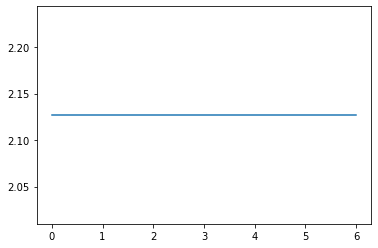

In [14]:
import matplotlib.pyplot as plt
plt.plot(best_tft.predict(data_df, return_index = True)[0][0])

In [15]:
train_target = data_df[(data_df['item'] == "1") & (data_df['store'] == "1")]
train_target
plt.plot(train_target['time_idx'][-365:], train_target['sales'][-365:])
train_target['time_idx'].max()


KeyError: 'item'

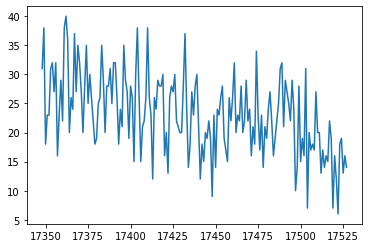

In [30]:
import pandas as pd 
actual_df = pd.read_csv("HistoricalSalesandActive Inventory_3years_testing_no_header.csv", names=['timestamp','item','store','sales'])
actual_df['time_idx'] = pd.DatetimeIndex(actual_df["timestamp"]).astype(int)/ 86400000000000   # equals to 1 day
actual_df['time_idx'] = actual_df['time_idx'].astype(int)

actual_target = actual_df[(actual_df['item'] == 1) & (actual_df['store'] == 1)][:180]

plt.plot(actual_target['time_idx'], actual_target['sales'])

In [31]:
checkpointed_model.predict(val_dataloader, return_index = True)[1]

,time_idx,item,store
0,17338,1,1
1,17338,1,2
2,17338,1,3
3,17338,1,4
4,17338,1,5


In [70]:
# baseline

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

AssertionError: Encoder lengths of at least 1 required to obtain last value

In [20]:
# prediction:
import torch
from pytorch_forecasting.metrics import SMAPE

Smape_metric = SMAPE()

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = torch.round(best_tft.predict(val_dataloader, show_progress_bar = True))
print("MAE:" ,(actuals - predictions).abs().mean())
print("RMSE: ", torch.sqrt(((actuals - predictions)**2).mean()))
print("SMAPE: ", Smape_metric(predictions, actuals))

Predict: 100%|██████████| 4/4 [00:03<00:00,  1.27 batches/s]

MAE: tensor(0.2502)
RMSE:  tensor(0.6773)
SMAPE:  tensor(0.1377)


rmse:  0.0


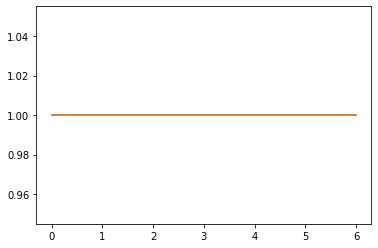

In [36]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

item_idx = 2
horizon = 180
print('rmse: ', math.sqrt(mean_squared_error(actuals[item_idx][:horizon], torch.round(predictions[item_idx][:horizon]))))
plt.plot(actuals[item_idx][:horizon])
plt.plot(torch.round(predictions[item_idx][:horizon]))

In [21]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
int_raw_predictions = raw_predictions.copy()

In [22]:
int_raw_predictions['prediction'] = torch.round(int_raw_predictions['prediction'])

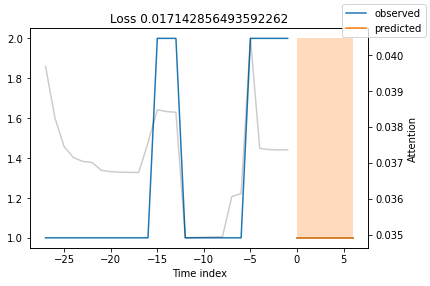

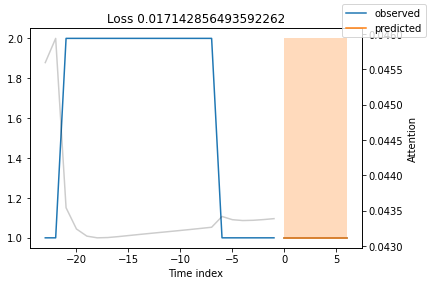

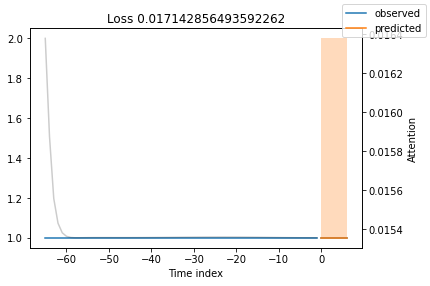

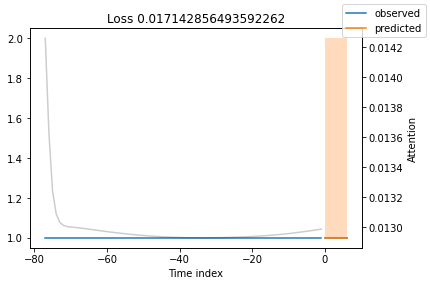

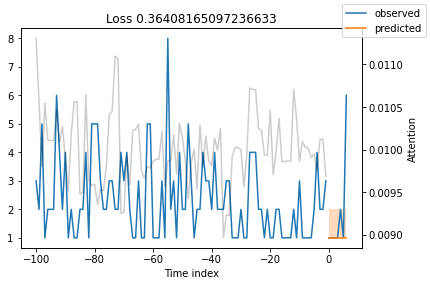

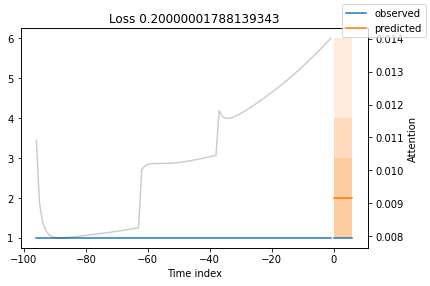

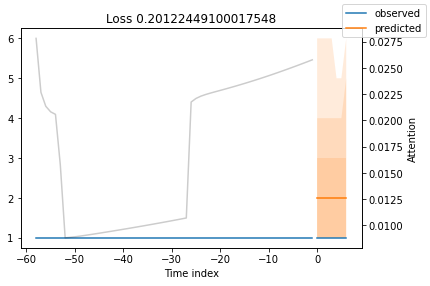

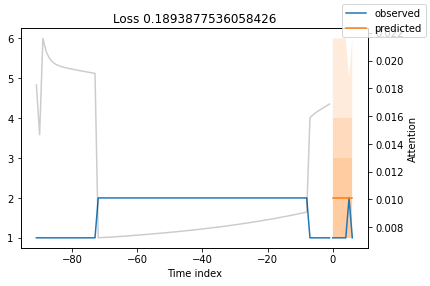

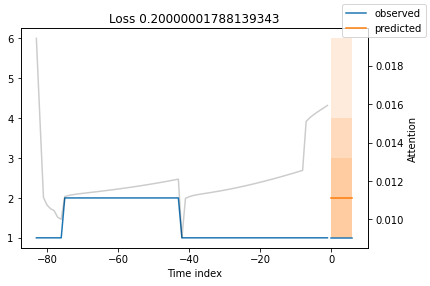

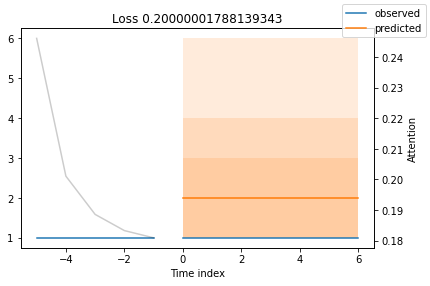

In [23]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, int_raw_predictions, idx=idx, add_loss_to_title=True);

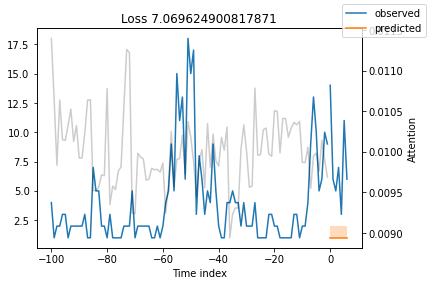

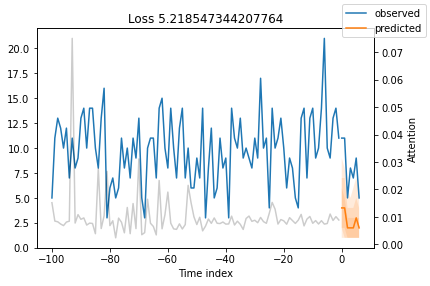

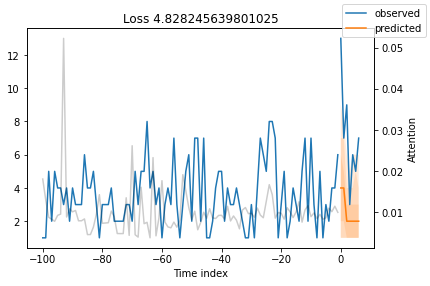

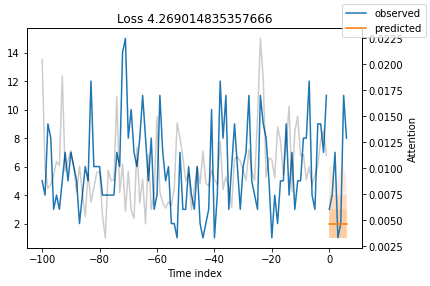

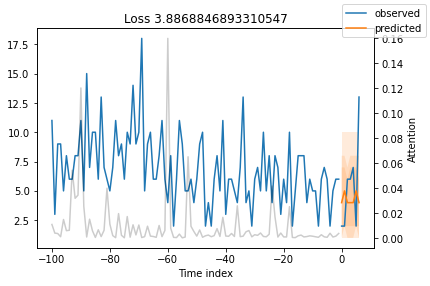

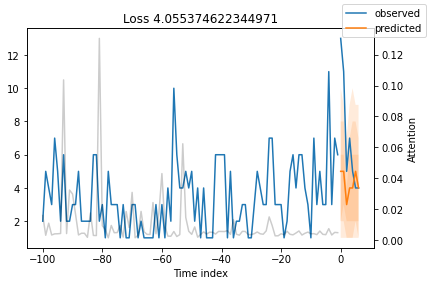

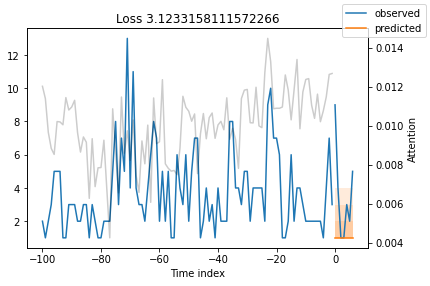

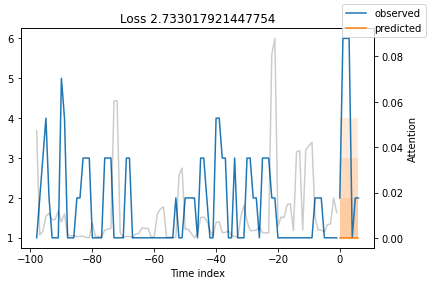

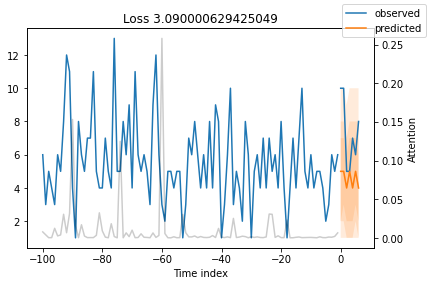

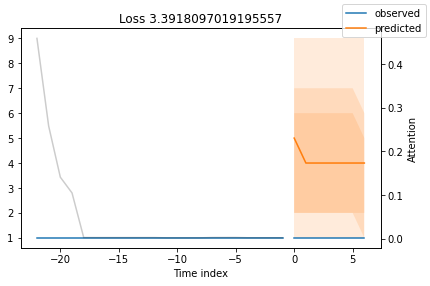

In [24]:
# 10 worst performers
from pytorch_forecasting.metrics import SMAPE, RMSE

mean_losses = RMSE(reduction="none")(predictions.int(), actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, int_raw_predictions, idx=indices[idx], add_loss_to_title=RMSE(quantiles=best_tft.loss.quantiles)
    );

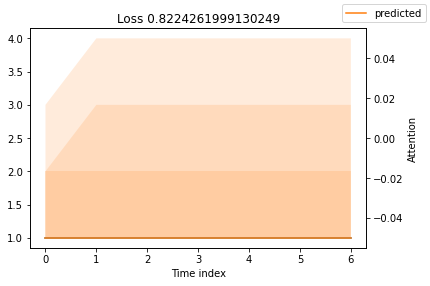

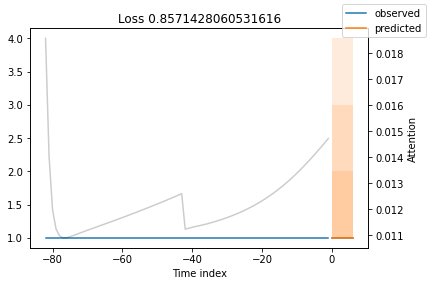

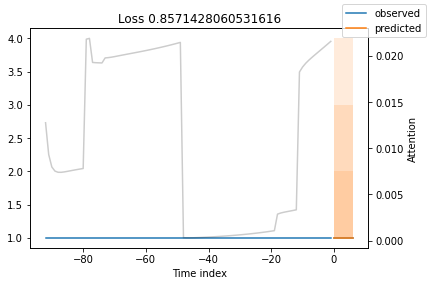

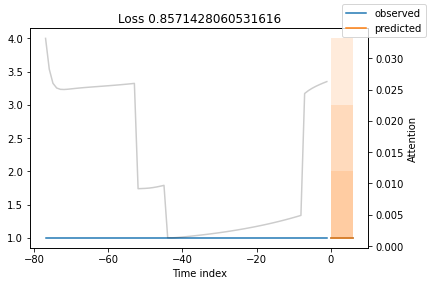

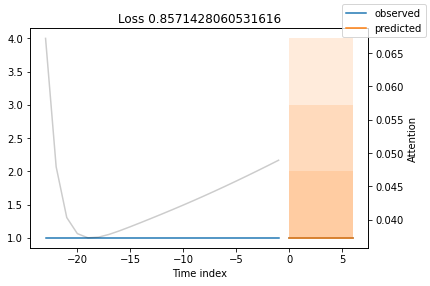

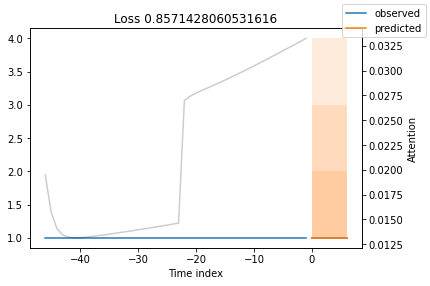

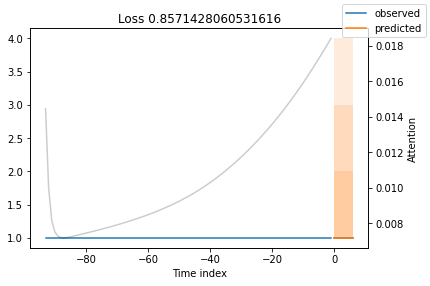

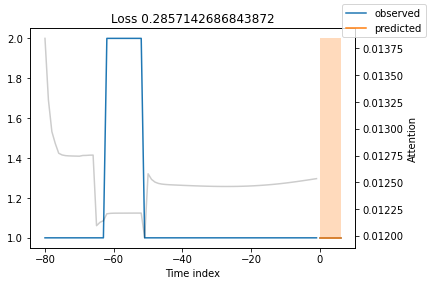

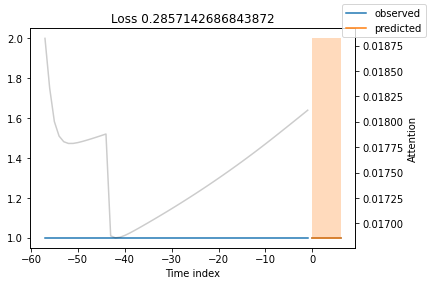

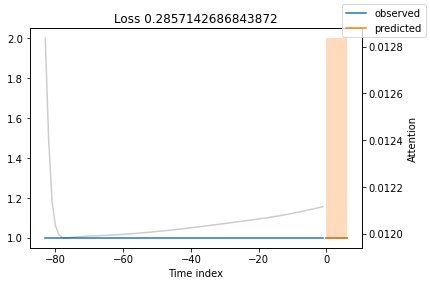

In [25]:
# 10 best performers
mean_losses = RMSE(reduction="none")(predictions.int(), actuals).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, int_raw_predictions, idx=indices[idx], add_loss_to_title=RMSE(quantiles=best_tft.loss.quantiles)
    );